# McDonald's Reviews - Deep Learning
Now we want to train a deep learning algorithm to predict the star rating of a review

In [268]:
import pandas as pd
import nltk
import spacy
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score


## Load data

In [269]:
df = pd.read_csv("csv/mcdonalds_reviews.csv", encoding="latin-1")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18149 entries, 0 to 18148
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   business_id  18149 non-null  object 
 1   stars        18149 non-null  float64
 2   text         18149 non-null  object 
dtypes: float64(1), object(2)
memory usage: 425.5+ KB
None


In [270]:
df["stars"] = df["stars"].astype(int)

## Preprocessing

In [271]:
# make lowercase
df["text"] = df["text"].str.lower()

# tokenize
nltk.download('punkt')
df["text"] = df["text"].apply(lambda x: nltk.word_tokenize(x))

# remove punctuation
df["text"] = df["text"].apply(lambda x: [word for word in x if word.isalnum()])

# remove stopwords
spacy.cli.download('en_core_web_sm')
spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
df["text"]  = df["text"] .apply(lambda x: ' '.join([word for word in x if word not in stopwords]))

# lemmatize
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: ' '.join([wnl.lemmatize(word) for word in x.split()]))

# collapse whitespaces and remove leading and trailing whitespaces
df["text"] = df["text"].str.replace(' +', ' ')
df["text"] = df["text"].str.strip()

print(df["text"].head(10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flyin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flyin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\flyin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    mcdonalds closest home forever drive distance ...
1    know expect asked drive menu available actuall...
2    eaten gotten food time food fine standard mcdo...
3    mood quick bite thought place went mcdonald go...
4            amber tried old fry having cold burnt one
5      giving 5 star shamrock shake delicious bad year
6    good customer service great manager louder mic...
7    agree previous review satisfactory defectively...
8    mcdonalds need know serve purpose complain ina...
9    mcdonalds terrible place dirty employee long o...
Name: text, dtype: object


In [272]:
# balancing
balanced_df = df.groupby('stars').apply(lambda x: x.sample(n=891, random_state=1)).reset_index(drop = True)

# Start of new code for the deep learning model

We want to train a LSTM model to predict the star rating of a review.
We will use the Keras library to build the model.

Instead of using Bag of Words, here we will use word embeddings.

We provide the tokens in a sequence, which preserves the order of the words. This is important because the meaning of a sentence can change depending on the order of the words. With bag of words, the order of the words would be lost.

In [273]:
# first we need to find a good max length for the sequences
# we will use the 90th percentile of the length of the reviews
balanced_df['text'].str.split().str.len().quantile(0.9)

63.0

In [274]:
max_sequence_length = 63


# We need to give the tokens to a Keras tokenizer so that it can convert them to sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df["text"])

In [275]:
# we need to convert the tokens to sequences of integers
X_sequences = tokenizer.texts_to_sequences(balanced_df["text"])

In [276]:
# we need to pad the sequences to make them all the same length (shorter sequences will be padded and longer sequences will be truncated)
# 'post' means that we will pad/truncate at the end of the sequence
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0)

In [277]:
# we now have the reviews as sequences with a length of 63
print(X_padded[:10])

[[1705 5298  667 1705   29   23 5299  106  583    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   9  183  116   19   91  373  491   43   39   56  668   19   26  446
     1   92   47  616  446  185 3217  366   45  668   49   17    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 440   27    6  186   18   20  113   37  187   12   14  146   28  170
    35    2 1055    2  440   58   37  652  992   35  240  250   35   12
    14   28   69   37  277   12   97  186   18  187   12   27   37   69
    37  300  175  385   30   39   53   12    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  20 1259  234  289 

As we can see, shorter reviews are padded with zeros at the end

In [278]:
vocab_size = len(tokenizer.word_index) + 1 # the number of unique words in the vocabulary

print("Vocabulary size: ", vocab_size)

Vocabulary size:  10115


## Define the model

In [279]:
embedding_dim = 100 # the dimension of the embedding vectors

# We are using a sequential model, which means that we can just add layers one after the other
model = Sequential()

# The first layer is an embedding layer, which will convert the tokens to embedding vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# The second layer is the LSTM layer
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# The third layer gives us a single output value that is linearly activated
model.add(Dense(units=1, activation='linear'))

It might seem counterintiutive to use a linear activation function for the output layer, since we are trying to build a classifier.
However, in this case it makes more sense to build a regressor, since the star ratings are numbers and not actually categories.
This can help our loss function, because it can for example know that a prediction of 4.9 is closer to the true value of 5 than a prediction of 4.5

It can also help us create cool visualizations later on.

In [280]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [281]:
y = balanced_df['stars']
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

## Train the model

In [282]:
# we can also give the fit function a validation split, which will use 10% of the training data as validation data
# this enables us to compare the loss on the training data and the validation data for each epoch
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.1)

Epoch 1/20
65/65 [==============================] - 20s 234ms/step - loss: 2.8766 - mae: 1.3937 - val_loss: 1.9164 - val_mae: 1.2011
Epoch 2/20
65/65 [==============================] - 15s 235ms/step - loss: 1.9813 - mae: 1.2074 - val_loss: 1.9045 - val_mae: 1.1967
Epoch 3/20
65/65 [==============================] - 15s 227ms/step - loss: 1.9552 - mae: 1.2012 - val_loss: 1.8508 - val_mae: 1.1676
Epoch 4/20
65/65 [==============================] - 15s 233ms/step - loss: 1.8713 - mae: 1.1610 - val_loss: 1.7192 - val_mae: 1.1162
Epoch 5/20
65/65 [==============================] - 15s 233ms/step - loss: 1.2907 - mae: 0.9259 - val_loss: 1.0280 - val_mae: 0.7956
Epoch 6/20
65/65 [==============================] - 16s 240ms/step - loss: 0.8125 - mae: 0.7259 - val_loss: 1.0112 - val_mae: 0.7914
Epoch 7/20
65/65 [==============================] - 16s 250ms/step - loss: 0.5361 - mae: 0.5842 - val_loss: 0.9476 - val_mae: 0.7324
Epoch 8/20
65/65 [==============================] - 15s 234ms/step - 

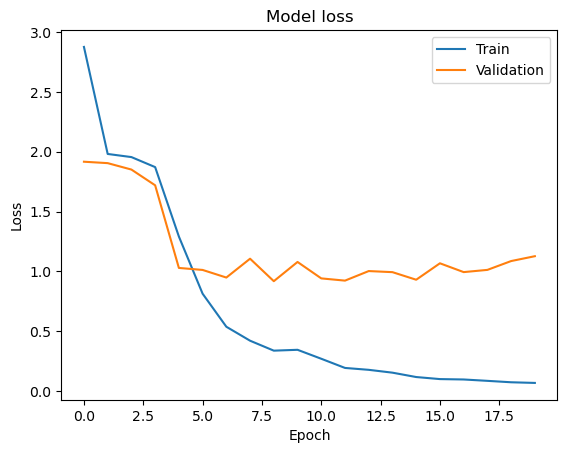

In [283]:
# graph the loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Since the Validation loss is higher than the training loss, we can see that the model is overfitting.

## Evaluate the model

In [284]:
# calculate the accuracy
y_pred = model.predict(X_test)

# round the predictions to the nearest integer
y_pred_int = np.rint(y_pred)

# clip the predictions to be within the range [1, 5]
y_pred_int = np.clip(y_pred_int, 1, 5)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_int)

print('Accuracy: ', accuracy)

28/28 [==============================] - 1s 38ms/step
Accuracy:  0.4276094276094276


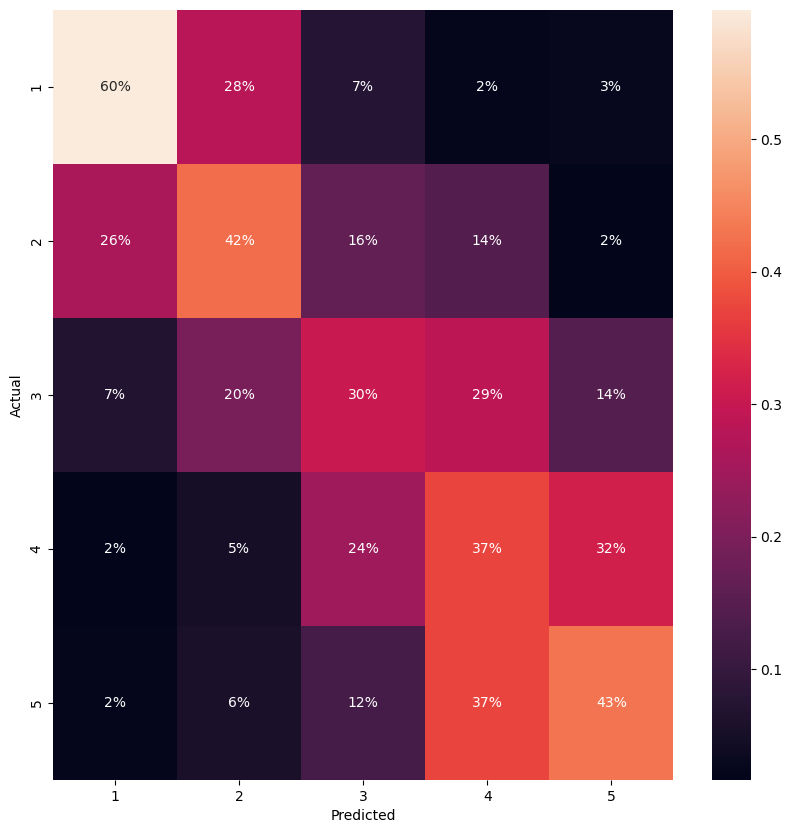

In [285]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_int, normalize='true')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [286]:
# Look at the accuracy with a tolerance of 1 star
def custom_accuracy(y_true, y_prediction):
    # Clip the predictions to be within the range [1, 5]
    y_prediction = np.clip(y_prediction, 1, 5)
    
    # Calculate the absolute difference between true and predicted values
    absolute_diff = np.abs(y_true - y_prediction)
    
    # Check if the absolute difference is within the tolerance of ±1
    within_tolerance = np.less_equal(absolute_diff, 1)
    
    # Calculate the percentage of predictions within the tolerance
    return np.mean(within_tolerance)

print(custom_accuracy(y_test, y_pred_int.flatten()))

0.8473625140291807


Again the accuracy is a lot higher when we allow the model to be off by 1 star.

Since our model is a regressor, we can also look at the mean absolute error.

In [287]:
# calculate the mean absolute error
mae = np.mean(np.abs(y_test - y_pred.flatten()))

print('Mean absolute error: ', mae)

Mean absolute error:  0.8010738635839169


This tells us that our prediction is off by ~0.8 stars on average.

Let's look at a graph showing the predicted values for true 1 star reviews.

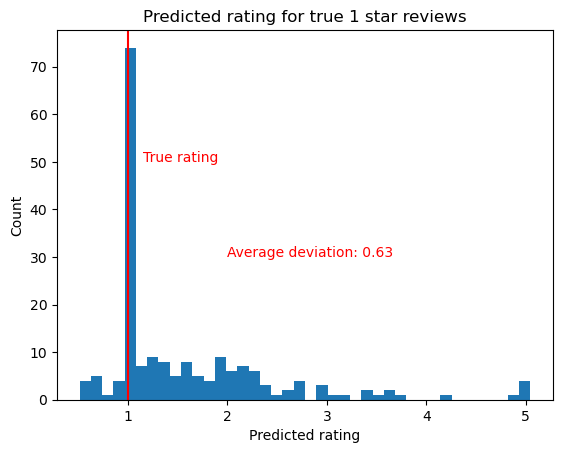

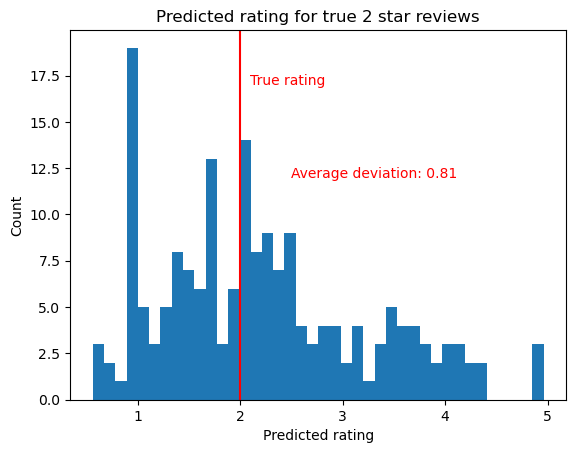

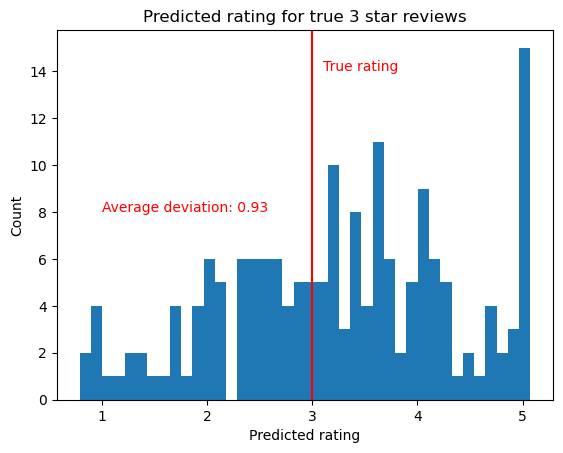

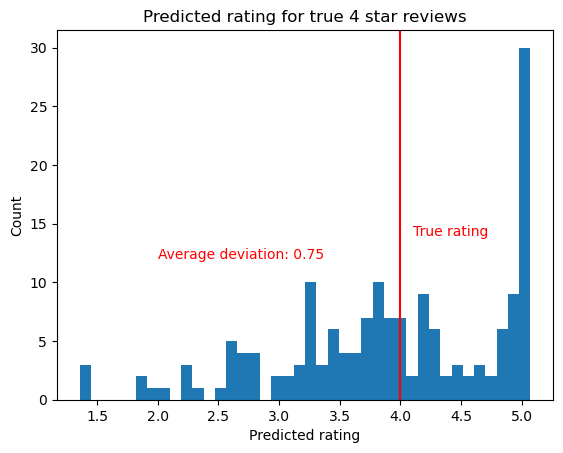

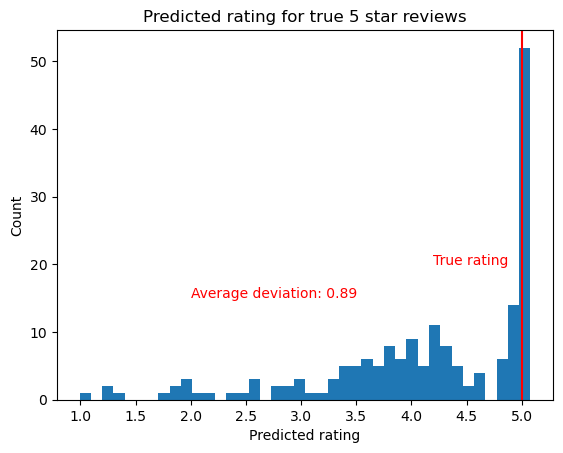

In [293]:
# plot a line graph showing the predicted values for true 1 star reviews
plt.hist(y_pred[y_test == 1], bins=40)
plt.title('Predicted rating for true 1 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=1, color='red')
plt.text(1.15, 50, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 1] - y_pred[y_test == 1].flatten()))
plt.text(2, 30, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 2 star reviews
plt.hist(y_pred[y_test == 2], bins=40)
plt.title('Predicted rating for true 2 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=2, color='red')
plt.text(2.1, 17, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 2] - y_pred[y_test == 2].flatten()))
plt.text(2.5, 12, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 3 star reviews
plt.hist(y_pred[y_test == 3], bins=40)
plt.title('Predicted rating for true 3 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=3, color='red')
plt.text(3.1, 14, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 3] - y_pred[y_test == 3].flatten()))
plt.text(1, 8, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 4 star reviews
plt.hist(y_pred[y_test == 4], bins=40)
plt.title('Predicted rating for true 4 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=4, color='red')
plt.text(4.1, 14, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 4] - y_pred[y_test == 4].flatten()))
plt.text(2, 12, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 5 star reviews
plt.hist(y_pred[y_test == 5], bins=40)
plt.title('Predicted rating for true 5 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=5, color='red')
plt.text(4.2, 20, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 5] - y_pred[y_test == 5].flatten()))
plt.text(2, 15, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

## Try training on unbalanced data

In [143]:
df['text'].str.split().str.len().quantile(0.9)

68.0

In [144]:
max_sequence_length = 68

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["text"])
X_sequences = tokenizer.texts_to_sequences(df["text"])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0)

vocab_size = len(tokenizer.word_index) + 1  # the number of unique words in the vocabulary

print("Vocabulary size: ", vocab_size)

## Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
y = df['stars']

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

Vocabulary size:  19192


In [145]:
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.1)

Epoch 1/20
262/262 [==============================] - 68s 240ms/step - loss: 1.8057 - mae: 1.0612 - val_loss: 1.5783 - val_mae: 1.0135
Epoch 2/20
262/262 [==============================] - 61s 232ms/step - loss: 1.4338 - mae: 0.8875 - val_loss: 1.2768 - val_mae: 0.8212
Epoch 3/20
262/262 [==============================] - 66s 251ms/step - loss: 1.3046 - mae: 0.8166 - val_loss: 1.2707 - val_mae: 0.7816
Epoch 4/20
262/262 [==============================] - 66s 253ms/step - loss: 1.2473 - mae: 0.7930 - val_loss: 1.2089 - val_mae: 0.8166
Epoch 5/20
262/262 [==============================] - 65s 247ms/step - loss: 1.2319 - mae: 0.7870 - val_loss: 1.3261 - val_mae: 0.8707
Epoch 6/20
262/262 [==============================] - 60s 229ms/step - loss: 1.0026 - mae: 0.7022 - val_loss: 0.9494 - val_mae: 0.7113
Epoch 7/20
262/262 [==============================] - 60s 229ms/step - loss: 0.7424 - mae: 0.5826 - val_loss: 0.7138 - val_mae: 0.5302
Epoch 8/20
262/262 [==============================] - 5

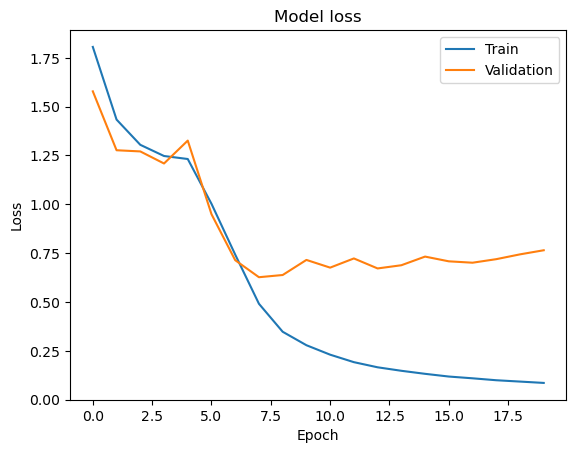

In [146]:
# graph the loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [147]:
## Evaluate the model
# calculate the accuracy
y_pred = model.predict(X_test)

# round the predictions to the nearest integer
y_pred_int = np.rint(y_pred)

# clip the predictions to be within the range [1, 5]
y_pred_int = np.clip(y_pred_int, 1, 5)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_int)

print('Accuracy: ', accuracy)

114/114 [==============================] - 5s 38ms/step
Accuracy:  0.6856749311294766


The accuracy looks quite good at first glance, but again we have to look at the balanced accuracy to get the full picture.

In [150]:
print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred_int))

Balanced accuracy:  0.4080761700877561


It looks like the model is worse when trained on unbalanced data.

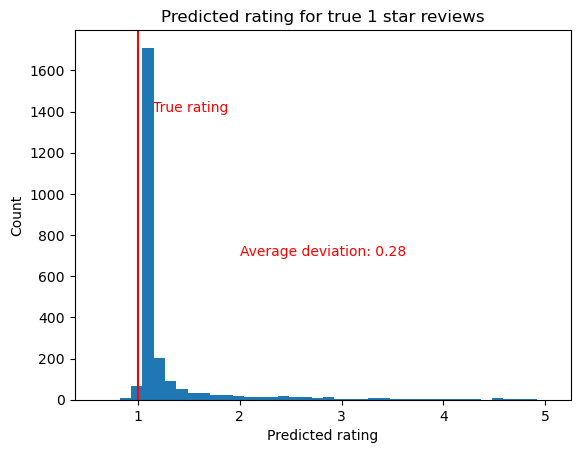

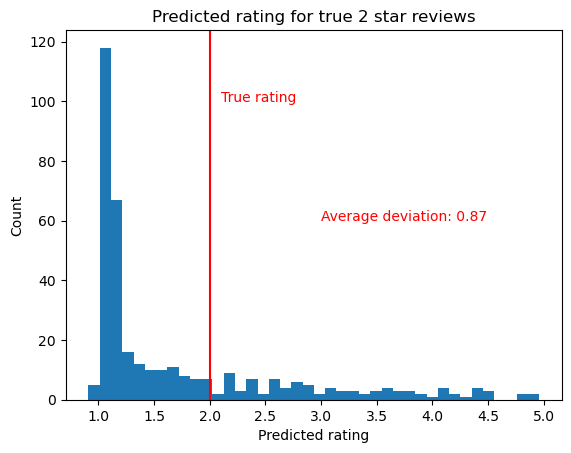

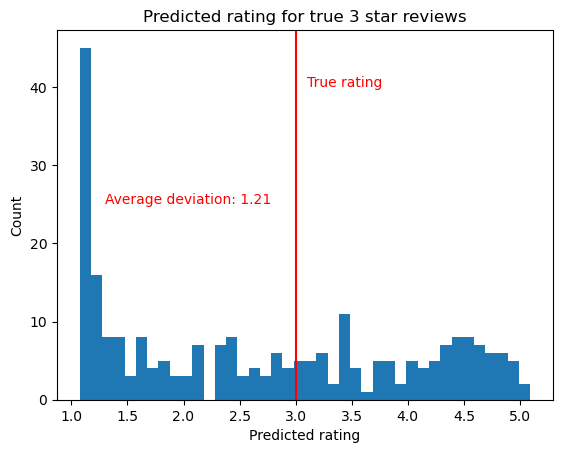

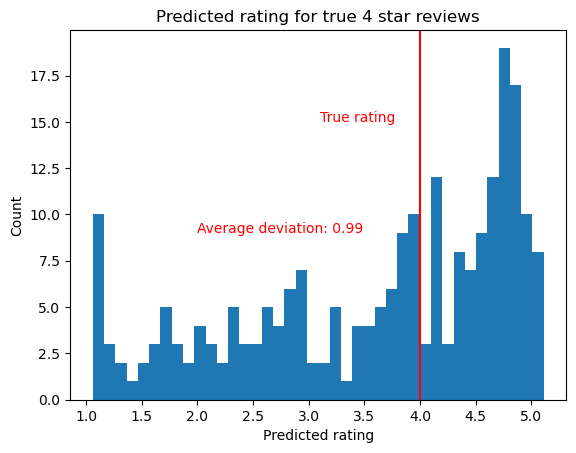

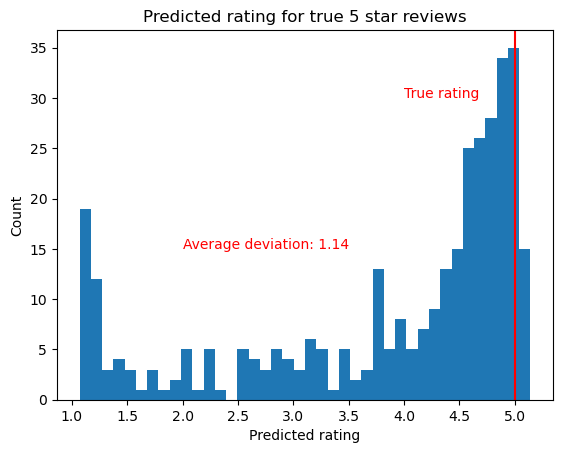

In [153]:
# plot a line graph showing the predicted values for true 1 star reviews
plt.hist(y_pred[y_test == 1], bins=40)
plt.title('Predicted rating for true 1 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=1, color='red')
plt.text(1.15, 1400, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 1] - y_pred[y_test == 1].flatten()))
plt.text(2, 700, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 2 star reviews
plt.hist(y_pred[y_test == 2], bins=40)
plt.title('Predicted rating for true 2 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=2, color='red')
plt.text(2.1, 100, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 2] - y_pred[y_test == 2].flatten()))
plt.text(3, 60, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 3 star reviews
plt.hist(y_pred[y_test == 3], bins=40)
plt.title('Predicted rating for true 3 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=3, color='red')
plt.text(3.1, 40, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 3] - y_pred[y_test == 3].flatten()))
plt.text(1.3, 25, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 4 star reviews
plt.hist(y_pred[y_test == 4], bins=40)
plt.title('Predicted rating for true 4 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=4, color='red')
plt.text(3.1, 15, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 4] - y_pred[y_test == 4].flatten()))
plt.text(2, 9, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

# 5 star reviews
plt.hist(y_pred[y_test == 5], bins=40)
plt.title('Predicted rating for true 5 star reviews')
plt.xlabel('Predicted rating')
plt.ylabel('Count')
plt.axvline(x=5, color='red')
plt.text(4, 30, 'True rating', color='red')
deviation = np.mean(np.abs(y_test[y_test == 5] - y_pred[y_test == 5].flatten()))
plt.text(2, 15, 'Average deviation: ' + str(round(deviation, 2)), color='red')
plt.show()

## Try to improve the model by using pre-trained word embeddings

In [266]:
max_sequence_length = 63

tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df["text"])
X_sequences = tokenizer.texts_to_sequences(balanced_df["text"])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0)

embedding_dim = 300  # the dimension of the embedding vectors
vocab_size = len(tokenizer.word_index) + 1  # the number of unique words in the vocabulary

In [ ]:
# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    
    # print progress every 100 words
    if i % 100 == 0:
        print(i)
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [241]:
model = Sequential()

# Use pre-trained GloVe embeddings
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
y = balanced_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [242]:
# this enables us to compare the loss on the training data and the validation data for each epoch
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.1)

Epoch 1/20
65/65 [==============================] - 21s 253ms/step - loss: 3.0121 - mae: 1.4132 - val_loss: 1.9537 - val_mae: 1.2176
Epoch 2/20
65/65 [==============================] - 16s 248ms/step - loss: 1.9696 - mae: 1.2017 - val_loss: 1.9458 - val_mae: 1.2118
Epoch 3/20
65/65 [==============================] - 16s 247ms/step - loss: 1.9310 - mae: 1.1844 - val_loss: 1.8615 - val_mae: 1.1817
Epoch 4/20
65/65 [==============================] - 16s 248ms/step - loss: 1.6164 - mae: 1.0767 - val_loss: 1.0905 - val_mae: 0.8687
Epoch 5/20
65/65 [==============================] - 17s 264ms/step - loss: 1.0528 - mae: 0.8373 - val_loss: 0.8637 - val_mae: 0.7391
Epoch 6/20
65/65 [==============================] - 16s 246ms/step - loss: 0.8798 - mae: 0.7587 - val_loss: 0.8519 - val_mae: 0.7271
Epoch 7/20
65/65 [==============================] - 16s 245ms/step - loss: 0.8237 - mae: 0.7331 - val_loss: 0.8223 - val_mae: 0.7121
Epoch 8/20
65/65 [==============================] - 16s 246ms/step - 

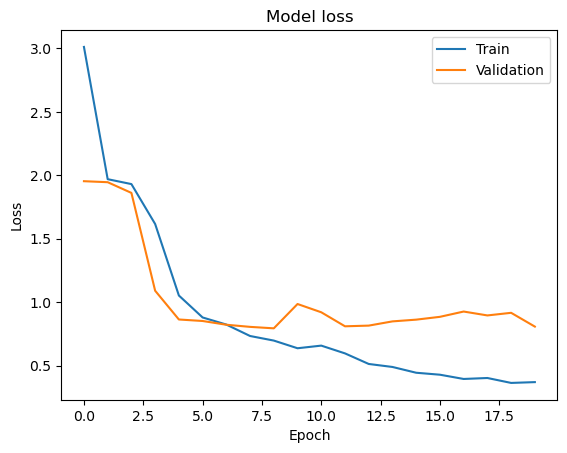

In [243]:
# graph the loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [245]:
## Evaluate the model
# calculate the accuracy
y_pred = model.predict(X_test)

# round the predictions to the nearest integer
y_pred_int = np.rint(y_pred)

# clip the predictions to be within the range [1, 5]
y_pred_int = np.clip(y_pred_int, 1, 5)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_int)

print('Accuracy: ', accuracy)

28/28 [==============================] - 2s 40ms/step
Accuracy:  0.4769921436588103


The accuracy is a bit better!

Since the model is still overfitting, lets try some hyperparameter tuning.

In [246]:
max_sequence_length = 20

tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df["text"])
X_sequences = tokenizer.texts_to_sequences(balanced_df["text"])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0)

vocab_size = len(tokenizer.word_index) + 1

In [247]:
# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [262]:
model = Sequential()

# Use pre-trained GloVe embeddings
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))

# reduce the number of LSTM units to avoid overfitting
model.add(LSTM(units=64, dropout=0.4, recurrent_dropout=0.4))

# add a batch normalization layer
model.add(BatchNormalization())

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

y = balanced_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
# this enables us to compare the loss on the training data and the validation data for each epoch

In [263]:
model.fit(X_train, y_train, epochs=15, batch_size=5, validation_split=0.1)

Epoch 1/15
642/642 [==============================] - 23s 29ms/step - loss: 3.8282 - mae: 1.5467 - val_loss: 1.5912 - val_mae: 1.0240
Epoch 2/15
642/642 [==============================] - 18s 28ms/step - loss: 1.5838 - mae: 1.0192 - val_loss: 1.1940 - val_mae: 0.8633
Epoch 3/15
642/642 [==============================] - 18s 28ms/step - loss: 1.4195 - mae: 0.9656 - val_loss: 1.2226 - val_mae: 0.8431
Epoch 4/15
642/642 [==============================] - 18s 28ms/step - loss: 1.2907 - mae: 0.9141 - val_loss: 1.0294 - val_mae: 0.7868
Epoch 5/15
642/642 [==============================] - 18s 28ms/step - loss: 1.1726 - mae: 0.8746 - val_loss: 1.3596 - val_mae: 0.9167
Epoch 6/15
642/642 [==============================] - 18s 28ms/step - loss: 1.1744 - mae: 0.8733 - val_loss: 1.0627 - val_mae: 0.7978
Epoch 7/15
642/642 [==============================] - 18s 28ms/step - loss: 1.1405 - mae: 0.8637 - val_loss: 1.1759 - val_mae: 0.8389
Epoch 8/15
642/642 [==============================] - 18s 28ms

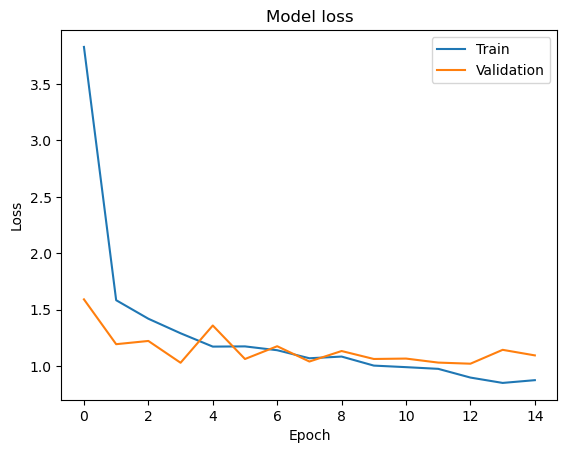

In [264]:
# graph the loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [265]:
## Evaluate the model
# calculate the accuracy
y_pred = model.predict(X_test)

# round the predictions to the nearest integer
y_pred_int = np.rint(y_pred)

# clip the predictions to be within the range [1, 5]
y_pred_int = np.clip(y_pred_int, 1, 5)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_int)

print('Accuracy: ', accuracy)

28/28 [==============================] - 1s 14ms/step
Accuracy:  0.40404040404040403
